提取特征
=================

In [1]:
import pandas as pd
import numpy as np
import SimpleITK as sitk
import os
import six
from radiomics import featureextractor

In [2]:
def ReadImage(dicompath):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(dicompath)
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    return image

In [3]:
def ReadMask(dicompath):
    for nii in os.listdir(dicompath):
        if nii.split('.')[-1] == 'gz':
            mask = sitk.ReadImage(os.path.join(dicompath,nii))
    return mask

In [21]:
def RadiomicsFeature(image, mask, ID):
    extractor = featureextractor.RadiomicsFeatureExtractor(geometryTolerance=0.001, Lable = 5)  # lable 1 肿瘤， Lable 5 淋巴结
    result = extractor.execute(image, mask)
    features_dict = dict()
    features_dict['ID'] = ID
    df = pd.DataFrame()
    for key, val in six.iteritems(result):
        if 'diagnostics_Versions' in  key or 'diagnostics_Configuration' in key:#这些都是一些共有的特征，可以去掉
            continue
        features_dict[key + '_lymph'] = val
    df = df.append(pd.DataFrame.from_dict(features_dict.values()).T,ignore_index=True)
#print(index)
    df.columns = features_dict.keys()
    if not os.path.exists('result.csv'):
        df.to_csv('result.csv',mode='a',index=0)
    else:
        df.to_csv('result.csv',mode='a',index=0,header=False)

In [3]:
xlsx_filepath = 'D:/Desktop/ms/data.xls'
data = pd.read_excel(xlsx_filepath,usecols=[1],dtype = str)

In [6]:
data.head()

,住院号
0,0016483567
1,0000465981
2,0016657839
3,0016710554
4,0015365389


In [7]:
input_path = r'C:\wei\DATA'

In [22]:
# for index, row in data.iterrows():
#     for patient in os.listdir(input_path):
#         if patient.split(' ')[-1] == row['住院号']:
#             input = os.path.join(input_path,patient)
#             image = ReadImage(input)
#             mask = ReadMask(input)
#             RadiomicsFeature(image, mask, row['住院号'])

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

***
处理提取出来的特征
===

In [334]:
cancer_data = pd.read_csv('cancer.csv').T.drop(['ID']).T
cols = [x for i, x in enumerate(cancer_data.columns) if type(cancer_data.iat[1,i]) == str]
cancer_data = cancer_data.drop(cols,axis=1)

lymph_data = pd.read_csv('lymph.csv').T.drop(['ID']).T
cols = [x for i, x in enumerate(lymph_data.columns) if type(lymph_data.iat[1,i]) == str]
lymph_data=lymph_data.drop(cols,axis=1)

clinical_data1 = pd.read_excel(xlsx_filepath).T[5:11].T
clinical_data2 = pd.read_excel('D:/Desktop/ms/2-10.xls').T[2:50].T
data = pd.concat([clinical_data1,clinical_data2,cancer_data,lymph_data],axis=1)

lymph_data.shape

(52, 112)

In [335]:
#lable = [1,0,0,0,0,1,1,1,0,1,1,1,0,1,0,1,1,1,1,0,0,0,0,1,1,1,1,1,0,1,1,1,1,0,1,1,0,1,0,0,0,0,1,1,0,1,1,0,0,1,0,1]
lable =[1,	1,	1	,1	,0	,1	,1	,1	,1	,1	,1	,1,	0	,1,	1	,1,	1,	1,	1,	0,	0,	1,	0,	1,	1,	1,	1,	1,	0,	1,	1,	1,	1,	1,	1,	1,	1,	1,	0,	0,	1,	0,	1,	1,	0,	1,	1,	1,0,1,0,1]

data.insert(0, 'lable', lable)

In [336]:
from sklearn.model_selection import train_test_split #分割训练集和验证集
from sklearn.ensemble import RandomForestClassifier #导入随机森林分类器
#from sklearn.externals import joblib #用来保存 sklearn 训练好的模型
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.linear_model import LassoCV
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

In [337]:
X = data.T[1:].T
y = data['lable']
#先保存X的列名
columnNames = X.columns
X = X.astype(np.float32)#把x数据转换成np.float格式
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X) #对x进行均值-标准差归一化
X = pd.DataFrame(X,columns=columnNames)#转 DataFrame 格式
X0 = X[:15]
X = X[15:]
y0 = y[:15]
y = y[15:]

In [338]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 2021)

In [339]:
clf = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
scores = cross_val_score(model_forest, X, y, cv=5)
scores.mean()

0.725

In [340]:
# 自己建立Lasso进行alpha选择的范围
# 形成10为底的指数范围 10**（-10）~ 10**（1）,200个数值
alpha_range = np.linspace(-1,1,10)
#alpha_range在这个参数范围里挑出aplpha进行训练，cv是把数据集分5分，进行交叉验证，max_iter是训练10000轮
lsvc = LinearSVC(C=1, penalty="l1", dual=False).fit(X, y)
#进行训练

In [341]:
model = SelectFromModel(clf).fit(X, y)
X_new = model.transform(X)
#X0 = model.transform(X0)
X_new.shape

(37, 38)

In [342]:
#clf = DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=0)
#clf = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
clf = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
scores = cross_val_score(clf, X_new, y, cv=5)
scores.mean()

0.725

In [343]:
clf = ExtraTreesClassifier(n_estimators=40)
clf = clf.fit(X, y)
clf.feature_importances_

array([0.00128472, 0.00128472, 0.        , 0.02603049, 0.01020823,
       0.        , 0.00121811, 0.00528571, 0.        , 0.00309184,
       0.        , 0.00293264, 0.        , 0.        , 0.00585241,
       0.        , 0.        , 0.00171296, 0.01109684, 0.00392343,
       0.0043086 , 0.        , 0.00501653, 0.00498955, 0.01087261,
       0.00955453, 0.        , 0.0047004 , 0.00342593, 0.00171296,
       0.00572458, 0.02954108, 0.        , 0.00765123, 0.00256944,
       0.01022564, 0.00928807, 0.00256944, 0.00401887, 0.00750756,
       0.0114116 , 0.00460869, 0.00502469, 0.00076132, 0.00622377,
       0.00998141, 0.        , 0.01004419, 0.        , 0.00085648,
       0.        , 0.        , 0.        , 0.0072178 , 0.00599537,
       0.        , 0.00256944, 0.00233153, 0.        , 0.00085648,
       0.00187981, 0.00135949, 0.        , 0.00026102, 0.00400363,
       0.00200805, 0.00152943, 0.        , 0.00860288, 0.00407305,
       0.00228395, 0.00702905, 0.00274074, 0.00429172, 0.00266

In [344]:
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
X0 = model.transform(X0)
X_new.shape

(37, 104)

In [345]:
scores = cross_val_score(clf, X_new, y, cv=5)
scores.mean()

0.7499999999999999

网格搜索
=============

In [346]:
from sklearn.model_selection import GridSearchCV

In [347]:
#设定网格搜索的xgboost参数搜索范围，值搜索XGBoost的主要6个参数
param_dist = {
        'n_estimators':range(10,15,1),
        'max_depth':range(11,15,1),
        'min_samples_split':range(2,4,1),
        'random_state':range(1000,4000,100)
        }
 
#param_dist字典类型，放入参数搜索范围
#scoring = 'neg_log_loss'，精度评价方式设定为“neg_log_loss“
#n_iter=300，训练300次，数值越大，获得的参数精度越大，但是搜索时间越长
#n_jobs = -1，使用所有的CPU进行训练，默认为1，使用1个CPU
grid = GridSearchCV(clf, param_dist, refit = True, cv = 5, verbose = 1, n_jobs = -1)
  
#在训练集上训练
grid.fit(X_new, y)
#返回最优的训练器
best_estimator = grid.best_estimator_
print(best_estimator)
grid.best_score_
#输出最优训练器的精度

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 1100 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 5100 tasks      | elapsed:   11.7s


ExtraTreesClassifier(max_depth=11, n_estimators=11, random_state=2700)


[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   12.8s finished


0.8071428571428572

绘制混淆矩阵和ROC图表
======

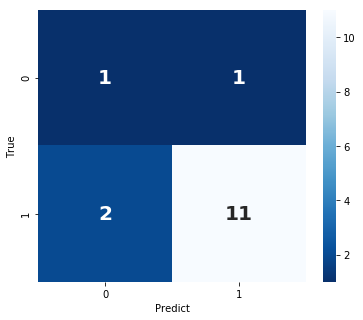

混淆矩阵为：
[[ 1  1]
 [ 2 11]]

计算各项指标：
              precision    recall  f1-score   support

           0       0.33      0.50      0.40         2
           1       0.92      0.85      0.88        13

    accuracy                           0.80        15
   macro avg       0.62      0.67      0.64        15
weighted avg       0.84      0.80      0.82        15



In [348]:
#绘制混淆矩阵
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

predict_label = best_estimator.predict(X0) #预测的标签
label = y0.to_list()  #真实标签
confusion = confusion_matrix(label, predict_label)#计算混淆矩阵

plt.figure(figsize=(6,5))
sns.heatmap(confusion,cmap='Blues_r',annot=True,annot_kws={'size':20,'weight':'bold', })#绘制混淆矩阵
plt.xlabel('Predict')
plt.ylabel('True')
plt.show()
print("混淆矩阵为：\n{}".format(confusion))
#计算灵敏度(相对标签1，HGG的召回率)
#计算特异度(相对标签0，LGG的召回率)
print("\n计算各项指标：")
print(classification_report(label, predict_label))

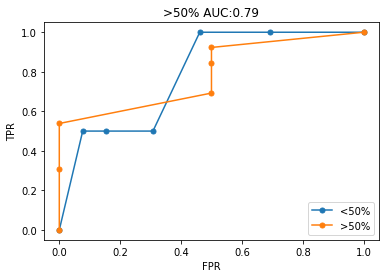

In [350]:
#绘制ROC曲线
from sklearn.metrics import roc_curve, roc_auc_score
kind = {'>50%':1,"<50%":0}
#model_forest = joblib.load('/home/aistudio/my_model_forest.model')#这是自己训练模型，记得替换自己的
label = y0.to_list()  #真实标签
y_predict = best_estimator.predict_proba(X0)#得到标签0和1对应的概率
fpr , tpr ,threshold = roc_curve(label, y_predict[:,kind['<50%']], pos_label=kind['<50%'])
fpr1 , tpr1 ,threshold = roc_curve(label, y_predict[:,kind['>50%']], pos_label=kind['>50%'])
plt.plot(fpr, tpr,marker='o', markersize=5,label='<50%')
plt.plot(fpr1, tpr1,marker='o', markersize=5,label='>50%')
plt.title(">50% AUC:{:.2f}".format(roc_auc_score(label,  y_predict[:,1]),fontsize=15))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc=4)
plt.show()